> 這個章節一共兩個模型。

## 分類問題（classification problem）
- Binary classification 二元分類：根據某人的健康參數預測他們是否患有心臟病。
- Multi-class classification
多類分類：確定照片是食物、人還是狗。
- Multi-label classification
多標籤分類：可以為目標分配多個選項。如預測應該為維琪百科條目分配哪些類別（例如數學，科學和哲學）。

## 分類神經網路的架構


＄ 輸入層（Input layer shape）：與特徵數量相同。

＄ 隱藏層（Hidden layer）：特定於問題，最小值 = 1，最大值 = 無限制

＄ 每個隱藏層的神經元數：針對具體問題，一般為 10 到 512

＄ 輸出層（Output layer shape）：1

＄ 啟動隱藏層（Hidden layer activation）：通常使用` ReLU（整流線性單元）`函數

＄ 輸出啟動（Output activation）：
- 二元分類：`torch.sigmoid`
- 多重分類：`torch.softmax`

＄ 損失函數（Loss function ）：
- 二元分類：`torch.nn.BCELoss`
- 多重分類：`torch.nn.CrossEntropyLoss`

＄ 優化器（Optimizer）：SGD（隨機梯度下降）、Adam等。




## 變數配置

In [16]:
class CFG:
  SEED = 42
  n_samples = 1000 # 總樣本數

# Standard PyTorch imports
import torch
from torch import nn
import matplotlib.pyplot as plt

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
# 可視化數據這一塊，會使用到別人寫的plt
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

## 製作分類數據

＄ 資料來源：使用 Scikit-Learn 中 make_circles() 的方法生成兩個帶有不同顏色圓點的圓圈。

In [4]:
from sklearn.datasets import make_circles

n_samples = CFG.n_samples # 總樣本數

# Create circles
X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=CFG.SEED)

In [7]:
# X為輸入張量，y為輸出的標籤（1,0）
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [13]:
# 使用panda將資料進行區分
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

# 查看label數量
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


### @ 輸入和輸出形狀

In [14]:
X.shape, y.shape

((1000, 2), (1000,))

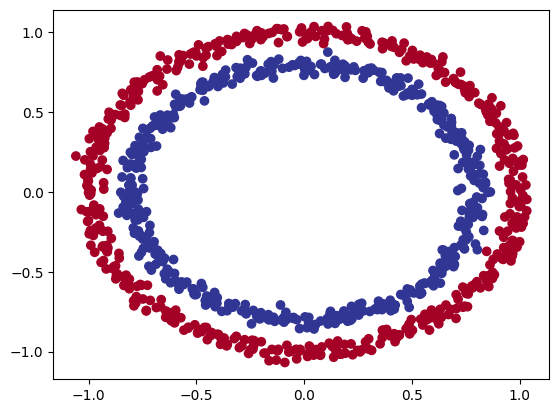

In [28]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### @將數據轉換為張量並創建訓練和測試拆分

In [15]:
import torch

# 我們的數據轉換為張量（現在我們的數據在 NumPy 陣列中，PyTorch 更喜歡使用 PyTorch 張量）。
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=CFG.SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# model_0 以線性模型做二元分類資料

## 構建模型

參考網站：
[TensorFlow Playground website](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.88571&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)


In [18]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # 接受 2 個特徵（X），生成 5 個特徵
        self.layer_2 = nn.Linear(in_features=5, out_features=1)  # 接受 5 個特徵，生成 1 個特徵（y）


    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.7510],
        [-0.8553],
        [-0.4813],
        [-0.8274],
        [-0.4871],
        [-0.5507],
        [-0.8397],
        [-0.7684],
        [-0.4815],
        [-0.8623]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 設置損失函數和優化器
＄ 可以用的優化器：
- `torch.optim.SGD()`:隨機梯度下降 （SGD） 優化器。
- `torch.optim.Adam()`:Adam 優化器。

＄ 可以用的損失函數：
- `torch.nn.BCELossWithLogits` 或 `torch.nn.BCELoss`:二元交叉熵損失，給二元分類使用。  
- `torch.nn.CrossEntropyLoss`:交叉熵損失，給多重分類使用
- `torch.nn.L1Loss`：平均絕對誤差 （MAE） 或 L1 損耗。
- `torch.nn.MSELoss`：均方誤差 （MSE） 或 L2 損耗。

In [21]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1)

## 計算精確率的函數

In [20]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## 訓練模型（ogits -> prediction probabilities -> prediction labels）

在forward()方法裡面，實現了兩層nn.Linear() ，其中內部調用了以下公式：


$$
\text{output} = \text{input} \times \text{weight}^T + \text{bias}
$$

其中模型的原始輸出通常被稱為logits。

這些數位很難解釋。 因此使用sigmoid 啟動函數將數據控制在01之間，這部分稱為prediction probabilities。

接下來要將這些數據決定代表10，在我們的例子中，由於我們正在處理二元分類，我們的理想輸出是 0 或 1。這些值可以被視為決策邊界（decision boundary）。


以這邊的例子，會以0.5做一個區分。（這就直接用四捨五入）

In [23]:
# 拿五筆出來做示範
# logits
y_logits = model_0(X_test.to(device))[:5]
y_logits

# prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

# prediction labels
y_preds = torch.round(y_pred_probs)

In [24]:
# 將所有資料跑一次
# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

## 構建訓練和測試迴圈


In [25]:
torch.manual_seed(CFG.SEED)

# 設置訓練周期的數量
epochs = 100

# 將數據放到目標設備上
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# 構建訓練和評估循環
for epoch in range(epochs):
    ### 訓練
    model_0.train()
    # 1. 正向傳播（模型輸出原始 logits）
    y_logits = model_0(X_train).squeeze()  # 擠壓以刪除多餘的 `1` 維度，除非模型和數據在同一設備上，否則這將不起作用
    y_pred = torch.round(torch.sigmoid(y_logits))  # 將 logits 轉換為預測概率，然後對預測概率進行四捨五入，得到預測標籤

    # 2. 計算損失/準確率
    # loss = loss_fn(torch.sigmoid(y_logits),  # 使用 nn.BCELoss，你需要對 logits 進行 torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits,  # 使用 nn.BCEWithLogitsLoss 可以處理原始 logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. 優化器梯度歸零
    optimizer.zero_grad()
    # 4. 損失反向傳播
    loss.backward()
    # 5. 優化器更新參數
    optimizer.step()

    ### 測試
    model_0.eval()
    with torch.inference_mode():
        # 1. 正向傳播
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. 計算測試集的損失/準確率
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

    # 每 10 個訓練周期打印出當前訓練和測試的損失和準確率
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.74511, Accuracy: 50.00% | Test loss: 0.73635, Test acc: 50.00%
Epoch: 10 | Loss: 0.71476, Accuracy: 50.00% | Test loss: 0.70905, Test acc: 50.00%
Epoch: 20 | Loss: 0.70243, Accuracy: 50.00% | Test loss: 0.69841, Test acc: 50.00%
Epoch: 30 | Loss: 0.69730, Accuracy: 50.00% | Test loss: 0.69436, Test acc: 50.00%
Epoch: 40 | Loss: 0.69512, Accuracy: 50.00% | Test loss: 0.69293, Test acc: 50.00%
Epoch: 50 | Loss: 0.69416, Accuracy: 41.62% | Test loss: 0.69254, Test acc: 42.50%
Epoch: 60 | Loss: 0.69371, Accuracy: 44.75% | Test loss: 0.69254, Test acc: 50.00%
Epoch: 70 | Loss: 0.69348, Accuracy: 47.25% | Test loss: 0.69268, Test acc: 51.50%
Epoch: 80 | Loss: 0.69334, Accuracy: 48.25% | Test loss: 0.69285, Test acc: 50.00%
Epoch: 90 | Loss: 0.69326, Accuracy: 49.50% | Test loss: 0.69303, Test acc: 48.00%


## 進行預測和評估模型

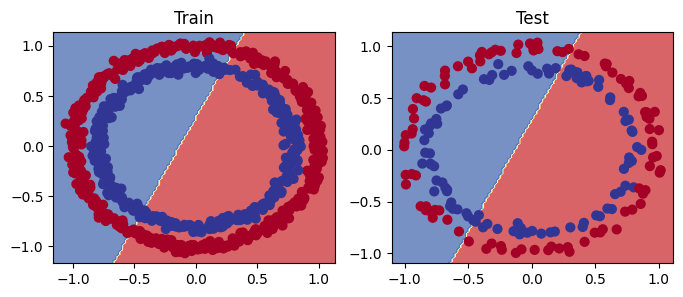

In [31]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# model_1以非線性模型做線性資料

## 重新創建非線性資料

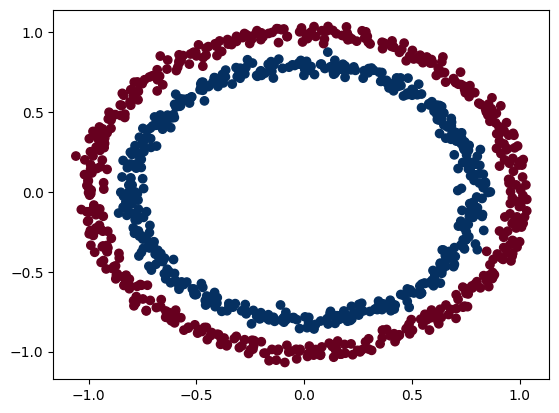

In [32]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=CFG.n_samples,noise=0.03,random_state=CFG.SEED)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

## 分類資料

In [ ]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=CFG.SEED)

## 構建非線性模型

＄ PyTorch 有一堆現成的非線性啟動函數，它們執行類似但不同的事情。

＄ 這邊新增ReLU（整流線性單元）。 torch.nn.ReLU()

＄ 在使用ReLU，相當於也有使用sigmoid，所以不需要再寫`self.sigmoid = nn.Sigmoid()`

In [34]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## 損失函數及優化器

In [35]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

## 訓練非線性模型

In [40]:
torch.manual_seed(CFG.SEED)
epochs = 1500


X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # logits -> 預測概率 -> 預測標籤

    # 計算損失和準確率
    loss = loss_fn(y_logits, y_train)  # 使用 BCEWithLogitsLoss 計算損失
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # 優化器梯度歸零
    optimizer.zero_grad()
    # 損失反向傳播
    loss.backward()
    # 優化器更新參數
    optimizer.step()

    ### 測試
    model_3.eval()
    with torch.inference_mode():
        # 正向傳播
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))  # logits -> 預測概率 -> 預測標籤
        # 計算測試集的損失和準確率
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # 每 100 個訓練周期打印出當前訓練和測試的損失和準確率
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.67298, Accuracy: 59.62% | Test Loss: 0.67067, Test Accuracy: 59.50%
Epoch: 100 | Loss: 0.66660, Accuracy: 61.12% | Test Loss: 0.66544, Test Accuracy: 62.00%
Epoch: 200 | Loss: 0.65590, Accuracy: 64.25% | Test Loss: 0.65706, Test Accuracy: 65.00%
Epoch: 300 | Loss: 0.63900, Accuracy: 67.50% | Test Loss: 0.64342, Test Accuracy: 69.00%
Epoch: 400 | Loss: 0.60738, Accuracy: 74.00% | Test Loss: 0.61813, Test Accuracy: 74.50%
Epoch: 500 | Loss: 0.54765, Accuracy: 90.00% | Test Loss: 0.56643, Test Accuracy: 85.00%
Epoch: 600 | Loss: 0.44890, Accuracy: 96.75% | Test Loss: 0.47627, Test Accuracy: 94.50%
Epoch: 700 | Loss: 0.32489, Accuracy: 99.00% | Test Loss: 0.35720, Test Accuracy: 98.50%
Epoch: 800 | Loss: 0.21187, Accuracy: 99.88% | Test Loss: 0.24666, Test Accuracy: 99.00%
Epoch: 900 | Loss: 0.15660, Accuracy: 99.75% | Test Loss: 0.19291, Test Accuracy: 98.50%
Epoch: 1000 | Loss: 0.10645, Accuracy: 99.88% | Test Loss: 0.14104, Test Accuracy: 99.50%
Epoch: 1100 | Loss: 0.

## 評估使用非線性啟動函數訓練的模型

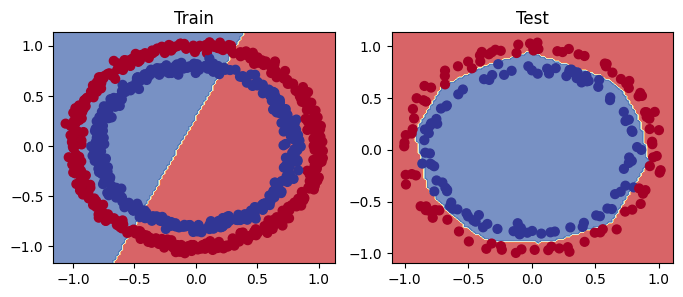

In [41]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()


plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# model_4 建立多類分類數據(mutli-class classification data)


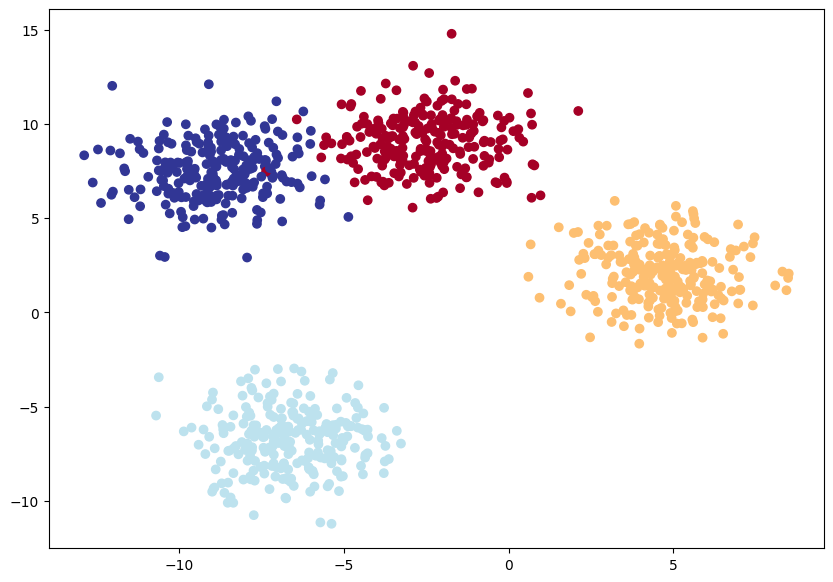

In [42]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2

# 使用 make_blobs() 創建一些多類數據
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # 輸入特徵
    centers=NUM_CLASSES, # 輸出分類
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=CFG.SEED
)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 將數據拆分為訓練集和測試集。
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=CFG.SEED
)

# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## 建構模型

In [43]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU()
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU()
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


model_4 = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,
    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 為多類 PyTorch 模型創建損失函數和優化器

In [48]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model_4.parameters(),
    lr=0.1)

## 獲取多類 PyTorch 模型的預測概率

torch.softmax() 函數用於計算 softmax 函數，它可以將一個具有任意形狀的張量映射到一個概率分佈，其中每個元素都會被壓縮到 (0, 1) 區間內，並且所有元素的總和為 1。



In [49]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

# 我們可以使用 torch.argmax() 檢查哪個索引具有最高值。
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)
tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


## 多類 PyTorch 模型創建訓練和測試迴圈

In [50]:
torch.manual_seed(CFG.SEED)
epochs = 100

# 將所有數據放到目標設備上
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### 訓練
    model_4.train()

    # 1. 正向傳播
    y_logits = model_4(X_blob_train)  # 模型輸出原始 logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # 從 logits -> 預測概率 -> 預測標籤

    # 2. 計算損失和準確率
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. 優化器梯度歸零
    optimizer.zero_grad()

    # 4. 損失反向傳播
    loss.backward()

    # 5. 優化器更新參數
    optimizer.step()

    ### 測試
    model_4.eval()
    with torch.inference_mode():
        # 1. 正向傳播
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. 計算測試集的損失和準確率
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)

    # 每 10 個訓練周期打印出當前訓練和測試的損失和準確率
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


## 使用 PyTorch 多類模型進行和評估預測

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


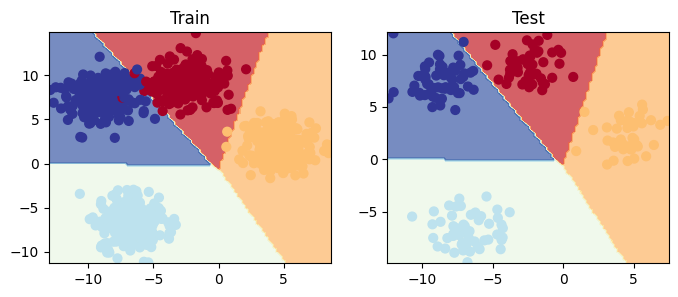

In [53]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")


plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 更多分類評價指標
＄ Accuracy
  `torchmetrics.Accuracy()` or `sklearn.metrics.accuracy_score()`


＄ Precision:真陽性占樣本總數的比例。精度越高，誤報率越低（模型預測 1 而本應為 0）。
  `torchmetrics.Precision()` or `sklearn.metrics.precision_score()`


＄ Recall:真陽性與真陽性和假陰性總數的比例（模型預測 0，而它應該是 1）。召回率越高，誤報率越低。
  `torchmetrics.Recall()` or `sklearn.metrics.recall_score()`


＄ F1-score:將精確度和召回率合併為一個指標。1 是最好的，0 是最差的。
  `torchmetrics.F1Score()` or `sklearn.metrics.f1_score() `


＄ Confusion matrix 混淆矩陣：以表格方式將預測值與真實值進行比較，如果 100% 正確，則矩陣中的所有值都將從左上到右下角（診斷線）。
  `torchmetrics.ConfusionMatrix` or `sklearn.metrics.plot_confusion_matrix()`


＄ Classification report 分類報告：收集一些主要的分類指標，如精確度、召回率和 f1 分數。
`sklearn.metrics.classification_report()`

In [54]:
# 試試這個 torchmetrics.Accuracy 指標。
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

tensor(0.9950)